In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pypvcell.solarcell import SQCell
from pypvcell.illumination import Illumination
from pcsc_util import calc_tp

spectrum loaded!


In [2]:
def eta_s(ill):
    """
    A function that calculates the efficiency of the silicon cell
    """
    band_gap=1.1
    sqcell=SQCell(band_gap,300)
    sqcell.set_input_spectrum(ill)
    
    return sqcell.get_eta()

def eta_3(ill):
    """
    A function that calculates the efficiency of the III-V solar cell from given spectrum
    """
    
    band_gap=1.7
    sqcell=SQCell(band_gap,300)
    sqcell.set_input_spectrum(ill)
    
    return sqcell.get_eta()

def calc_cp(total_area,c_3,c_s,a_3,a_s):
    
    return total_area*(a_s*c_s+a_3*c_3)

def no_bot_cell(ill):
    return 0

In [3]:
std_ill=Illumination("AM1.5g",concentration=1)

Test case 1: No bottom cell. III-V cell covers 50% of the whole area. The concentrated area is 20%.

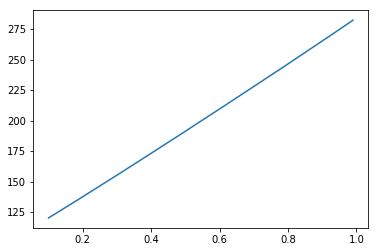

In [4]:
a_3=0.5 #III-V cell area
a_c=0.2 #concentrated sunlight area
f_c_arr=np.linspace(0.1,0.99,num=200)

tp_arr=[]
for f in f_c_arr:
    tp=calc_tp(std_ill,1,a_3=a_3,a_c=a_c,f_c=f,eta_s=no_bot_cell,eta_3=eta_3)
    tp_arr.append(tp)

tp_arr=np.array(tp_arr)

plt.plot(f_c_arr,tp_arr)
plt.show()

Same as previous. This time the concentrated area is 30% of the whole area. This should give identical result with previous setting.

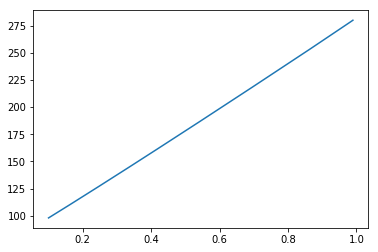

In [5]:
a_3=0.5 #III-V cell area
a_c=0.3 #concentrated sunlight area
f_c_arr=np.linspace(0.1,0.99,num=200)

tp_arr=[]
for f in f_c_arr:
    tp=calc_tp(std_ill,1,a_3=a_3,a_c=a_c,f_c=f,eta_s=no_bot_cell,eta_3=eta_3)
    tp_arr.append(tp)

tp_arr=np.array(tp_arr)

plt.plot(f_c_arr,tp_arr)
plt.show()

In [6]:
eta_3(std_ill)

0.2750444222590061

In this special case, we expect that when f_c very close to 99%, the efficiency would approach the ```eta_3()``` at one sun. It is indeed the case.

Test case 2: No bottom cell. Vary a_c, set a_c=a_3, and f_c=1. This is to simulate the standard concentration cell.

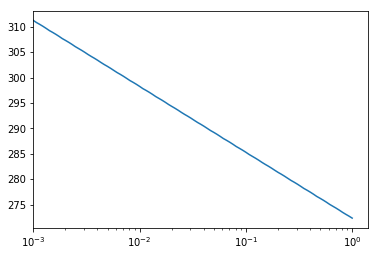

In [7]:
a_c_arr=np.logspace(-3,np.log10(0.999),num=100) #concentrated sunlight area
f_c=0.99

tp_arr=[]
for a_c in a_c_arr:
    tp=calc_tp(std_ill,1,a_3=a_c,a_c=a_c,f_c=f_c,eta_s=no_bot_cell,eta_3=eta_3)
    tp_arr.append(tp)

tp_arr=np.array(tp_arr)

plt.semilogx(a_c_arr,tp_arr)
plt.show()

Replot the above figure with concentration.

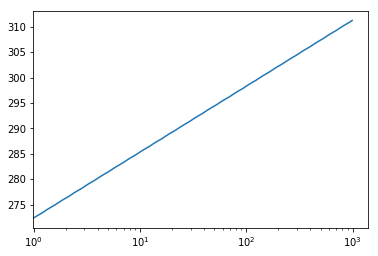

In [8]:
plt.semilogx(f_c/a_c_arr,tp_arr)
plt.show()

Start to plug in silicon cells

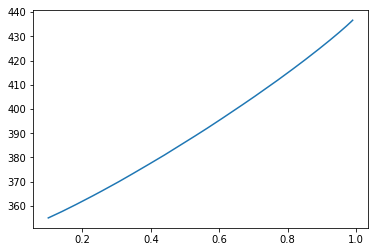

In [9]:
a_3=0.5 #III-V cell area
a_c=0.2 #concentrated sunlight area
f_c_arr=np.linspace(0.1,0.99,num=200)

tp_arr=[]
for f in f_c_arr:
    tp=calc_tp(std_ill,1,a_3=a_3,a_c=a_c,f_c=f,eta_s=eta_s,eta_3=eta_3)
    tp_arr.append(tp)

tp_arr=np.array(tp_arr)

plt.plot(f_c_arr,tp_arr)
plt.show()

### Calculate cost

Text(0,0.5,'areal cost per m^2')

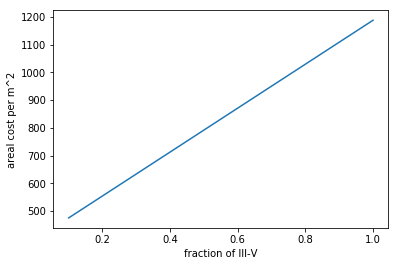

In [10]:
#Assume AM1.5g, 1000W/m^2, eta=18%, the areal cost of silicon module is:
test_c_s=2.2*0.18*1000
#Assume that III-V module areal cost is 3x more
test_c_3=test_c_s*3
test_a_3=np.linspace(0.1,1,num=50)
test_a_s=1-test_a_3
cp=[]
for i in range(test_a_3.shape[0]):
    cp.append(calc_cp(1,test_c_3,test_c_s,test_a_3[i],test_a_s[i]))

cp=np.array(cp)
plt.plot(test_a_3,cp)
plt.xlabel("fraction of III-V")
plt.ylabel("areal cost per m^2")

The above figure shows that high concentration reduces $/Wp.

### Putting cost and power together

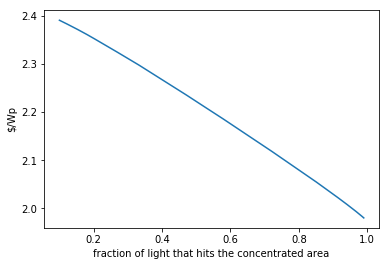

In [11]:
a_3=0.3 #III-V cell area
a_c=0.5 #concentrated sunlight area
f_c_arr=np.linspace(0.1,0.99,num=200)

tp_arr=[]
cp_arr=[]
for f in f_c_arr:
    tp=calc_tp(std_ill,1,a_3=a_3,a_c=a_c,f_c=f,eta_s=eta_s,eta_3=eta_3)
    cp_arr.append(calc_cp(1,test_c_3,test_c_s,a_3,1))
    tp_arr.append(tp)

tp_arr=np.array(tp_arr)
cp_arr=np.array(cp_arr)

plt.plot(f_c_arr,cp_arr/tp_arr)
plt.xlabel("fraction of light that hits the concentrated area")
plt.ylabel("$/Wp")
plt.show()

### Set-up a series of beta distribution
Beta distribution seems to be a good option to describe the probability of the fraction of light that hits the concentrated area. The x-axis is the fraction of light that hits the concentrated area (f_c). y-axis the probability denstiy.

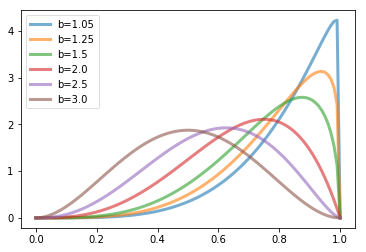

In [14]:
fig, ax = plt.subplots(1, 1)
b_arr=np.array([1.05,1.25,1.5,2,2.5,3])
for b in b_arr:
    a=6-b
    mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
    x = np.linspace(beta.ppf(0.0, a, b),
                  beta.ppf(1, a, b), 100)
    ax.plot(x, beta.pdf(x, a, b),
              lw=3, alpha=0.6, label='b=%s'%b)
ax.legend()

A few remarks. Different distribution describes the "ideality" of a concentrator system. This is independent of concentration. A way to think of this that low b value represents a high-quality tracker, whereas higher b value represents very poor tracker or even not tracked at all.

### Test different beta distribution

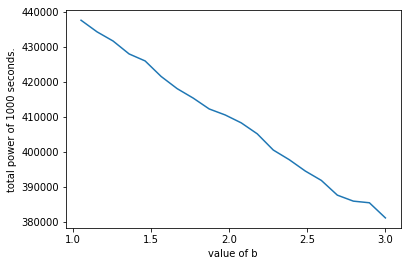

In [24]:
a_3=0.01 #III-V cell area
a_c=0.01 #concentrated sunlight area

b_arr=np.linspace(1.05,3,num=20)
tp_arr=[]
total_sampling_time=1000
for b in b_arr:
    total_power=0
    f_c_distri=np.random.beta(6-b,b,total_sampling_time)
    for f in f_c_distri:
        total_power+=calc_tp(std_ill,1,a_3=a_3,a_c=a_c,f_c=f,eta_s=eta_s,eta_3=eta_3)
    tp_arr.append(total_power)

plt.plot(b_arr,tp_arr)
plt.xlabel("value of b")
plt.ylabel("total power of %s seconds."%total_sampling_time)
plt.show()

As expected, smaller b values gives lower energy yields.

### Calculate energy yields vs. concentrated area, with different b value
This calculation assumes the area of III-V cell is identical to the concentration area.
#### Assuming III-V/Si mechanical stack cell

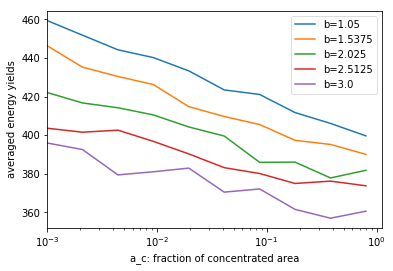

In [59]:
b_arr=np.linspace(1.05,3,num=5)
a_c_arr=np.logspace(-3,np.log10(0.8),num=10)

total_sampling_time=100
tp_arr=np.zeros((b_arr.shape[0],a_c_arr.shape[0]))
for i,b in enumerate(b_arr):
    for j,a_c in enumerate(a_c_arr):
        f_c_distri=np.random.beta(6-b,b,total_sampling_time)
        total_power=0
        for f in f_c_distri:
            total_power+=calc_tp(std_ill,1,a_3=a_c,a_c=a_c,f_c=f,eta_s=eta_s,eta_3=eta_3)
        tp_arr[i,j]=total_power
    plt.semilogx(a_c_arr,tp_arr[i,:]/total_sampling_time,label='b=%s'%b)

plt.xlabel("a_c: fraction of concentrated area")
plt.ylabel("averaged energy yields")
plt.legend()
plt.show()

- Even with poor tracking, high concentration (low a_c) still gives higher energy yields
- The energy output difference between good and back tracking becomes smaller in higher a_c, although very marginal.

Add pricing factor. Assuming the price of III-V is 10 times mores than silicon.

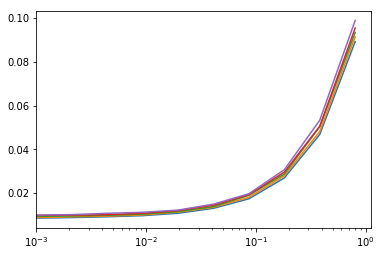

In [61]:
test_c_3=test_c_s*10
cp_arr=[calc_cp(1,test_c_3,test_c_s,a_3,1) for a_3 in a_c_arr]
for i in range(b_arr.shape[0]):
    plt.semilogx(a_c_arr,cp_arr/tp_arr[i,:])

The price are very close between good and bad tracker.

#### No silicon cell. III-V only.

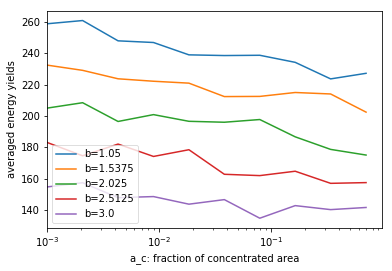

In [62]:
b_arr=np.linspace(1.05,3,num=5)
a_c_arr=np.logspace(-3,np.log10(0.7),num=10)

total_sampling_time=100
tp_arr=np.zeros((b_arr.shape[0],a_c_arr.shape[0]))
for i,b in enumerate(b_arr):
    for j,a_c in enumerate(a_c_arr):
        f_c_distri=np.random.beta(6-b,b,total_sampling_time)
        total_power=0
        for f in f_c_distri:
            total_power+=calc_tp(std_ill,1,a_3=a_c,a_c=a_c,f_c=f,eta_s=no_bot_cell,eta_3=eta_3)
        tp_arr[i,j]=total_power
    plt.semilogx(a_c_arr,tp_arr[i,:]/total_sampling_time,label='b=%s'%b)

plt.xlabel("a_c: fraction of concentrated area")
plt.ylabel("averaged energy yields")
plt.legend()
plt.show()

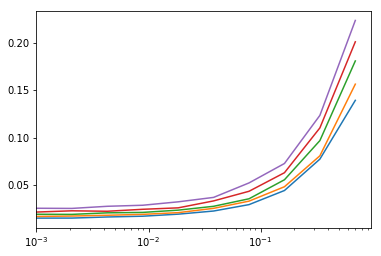

In [63]:
test_c_3=test_c_s*10
cp_arr=[calc_cp(1,test_c_3,test_c_s,a_3,1) for a_3 in a_c_arr]
for i in range(b_arr.shape[0]):
    plt.semilogx(a_c_arr,cp_arr/tp_arr[i,:])

- Adding silicon bottom cell does reduce the cost energy a little bit, especially for poor tracking and high concentration.
- Need further comparison for this.